<a href="https://colab.research.google.com/github/cdrowley/wine-quality/blob/main/wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data In

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, sep=';')
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


## EDA

In [17]:
def describe(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.describe()
        .T.round(1)
        .join(df.isnull().sum().to_frame("missing"))
        .join(df.agg("nunique").T.to_frame("unique"))
        .join(df.dtypes.to_frame("type"))
    )

describe(df)

,count,mean,std,min,25%,50%,75%,max,missing,unique,type
fixed acidity,1599.0,8.3,1.7,4.6,7.1,7.9,9.2,15.9,0,96,float64
volatile acidity,1599.0,0.5,0.2,0.1,0.4,0.5,0.6,1.6,0,143,float64
citric acid,1599.0,0.3,0.2,0.0,0.1,0.3,0.4,1.0,0,80,float64
residual sugar,1599.0,2.5,1.4,0.9,1.9,2.2,2.6,15.5,0,91,float64
chlorides,1599.0,0.1,0.0,0.0,0.1,0.1,0.1,0.6,0,153,float64
free sulfur dioxide,1599.0,15.9,10.5,1.0,7.0,14.0,21.0,72.0,0,60,float64
total sulfur dioxide,1599.0,46.5,32.9,6.0,22.0,38.0,62.0,289.0,0,144,float64
density,1599.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0,436,float64
pH,1599.0,3.3,0.2,2.7,3.2,3.3,3.4,4.0,0,89,float64
sulphates,1599.0,0.7,0.2,0.3,0.6,0.6,0.7,2.0,0,96,float64


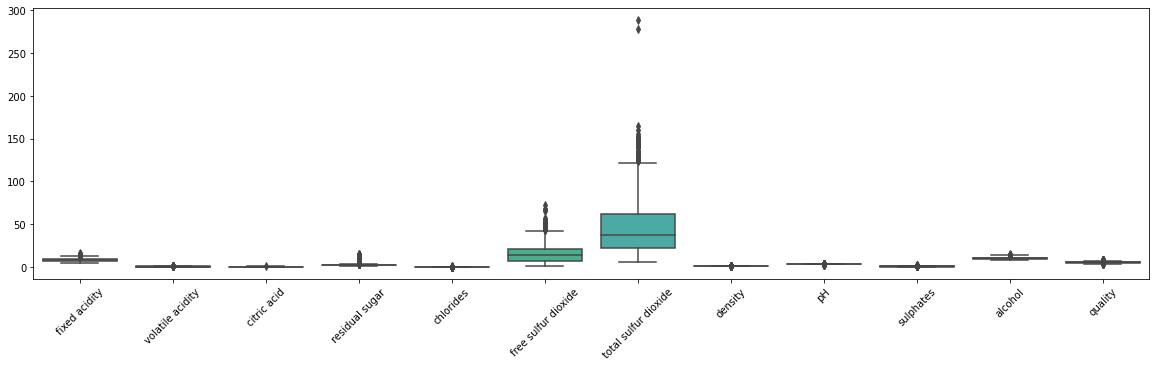

In [18]:
fig, x = plt.subplots(1, figsize=(20, 5))

ax = sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [19]:
# Remove extreme outliers
df = df.loc[df['total sulfur dioxide'] < 200]

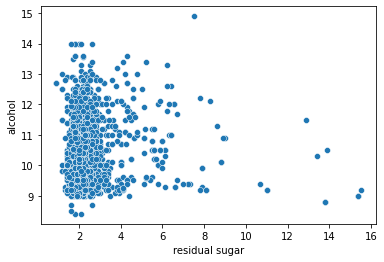

In [20]:
sns.scatterplot(x=df['residual sugar'], y=df['alcohol'])
plt.show()

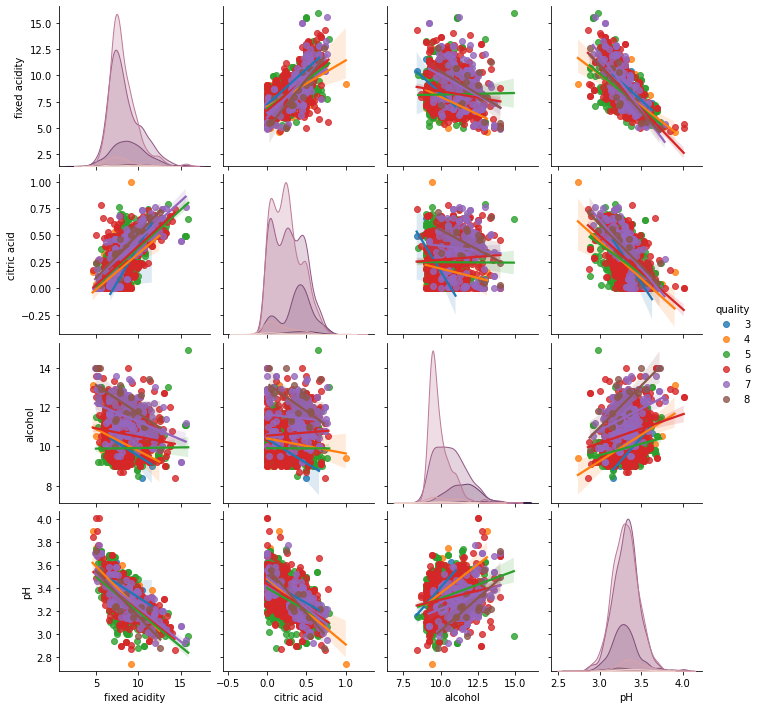

In [21]:
plot_cols = ['fixed acidity', 'citric acid', 'alcohol', 'pH', 'quality']
sns.pairplot(df[plot_cols], kind='reg', hue='quality')
plt.show()

## T-test for acidity on wine quality

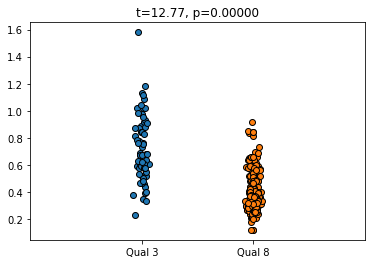

In [29]:
# extract samples (to test if means are significantly different)
x = df['volatile acidity'][df['quality'].isin([3, 4])]
y = df['volatile acidity'][df['quality'].isin([7, 8])]

plt.plot(np.random.randn(len(x))/30, x, 'o',
         np.random.randn(len(y))/30+1, y, 'o',
         markeredgecolor='k')

# ttest
ttest = stats.ttest_ind(x, y)

# plot
plt.xlim([-1, 2])
plt.xticks([0, 1], labels=['Qual 3', 'Qual 8'])
plt.title(f't={ttest[0]:.2f}, p={ttest[1]:.5f}')
plt.show()

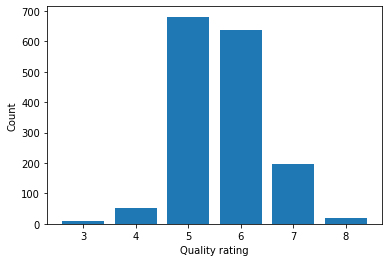

In [30]:
counts = df['quality'].value_counts()
plt.bar(list(counts.keys()), counts)
plt.xlabel('Quality rating')
plt.ylabel('Count')
plt.show()

# df['quality'].hist();

## Multiple Regression

In [31]:
import statsmodels.api as sm

dep_var = df['quality']
ind_vars = df.drop(labels='quality', axis=1)

ind_vars = sm.add_constant(ind_vars)
model = sm.OLS(endog=dep_var, exog=ind_vars).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     81.47
Date:                Sun, 13 Mar 2022   Prob (F-statistic):          1.30e-145
Time:                        12:43:33   Log-Likelihood:                -1564.5
No. Observations:                1597   AIC:                             3153.
Df Residuals:                    1585   BIC:                             3218.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.1410 

In [32]:
sig_cols = list(model.pvalues[model.pvalues < .05].keys())
print("\n".join(sig_cols))

# add dep variable to facet plot by
sig_cols.append('quality')

volatile acidity
chlorides
free sulfur dioxide
total sulfur dioxide
pH
sulphates
alcohol


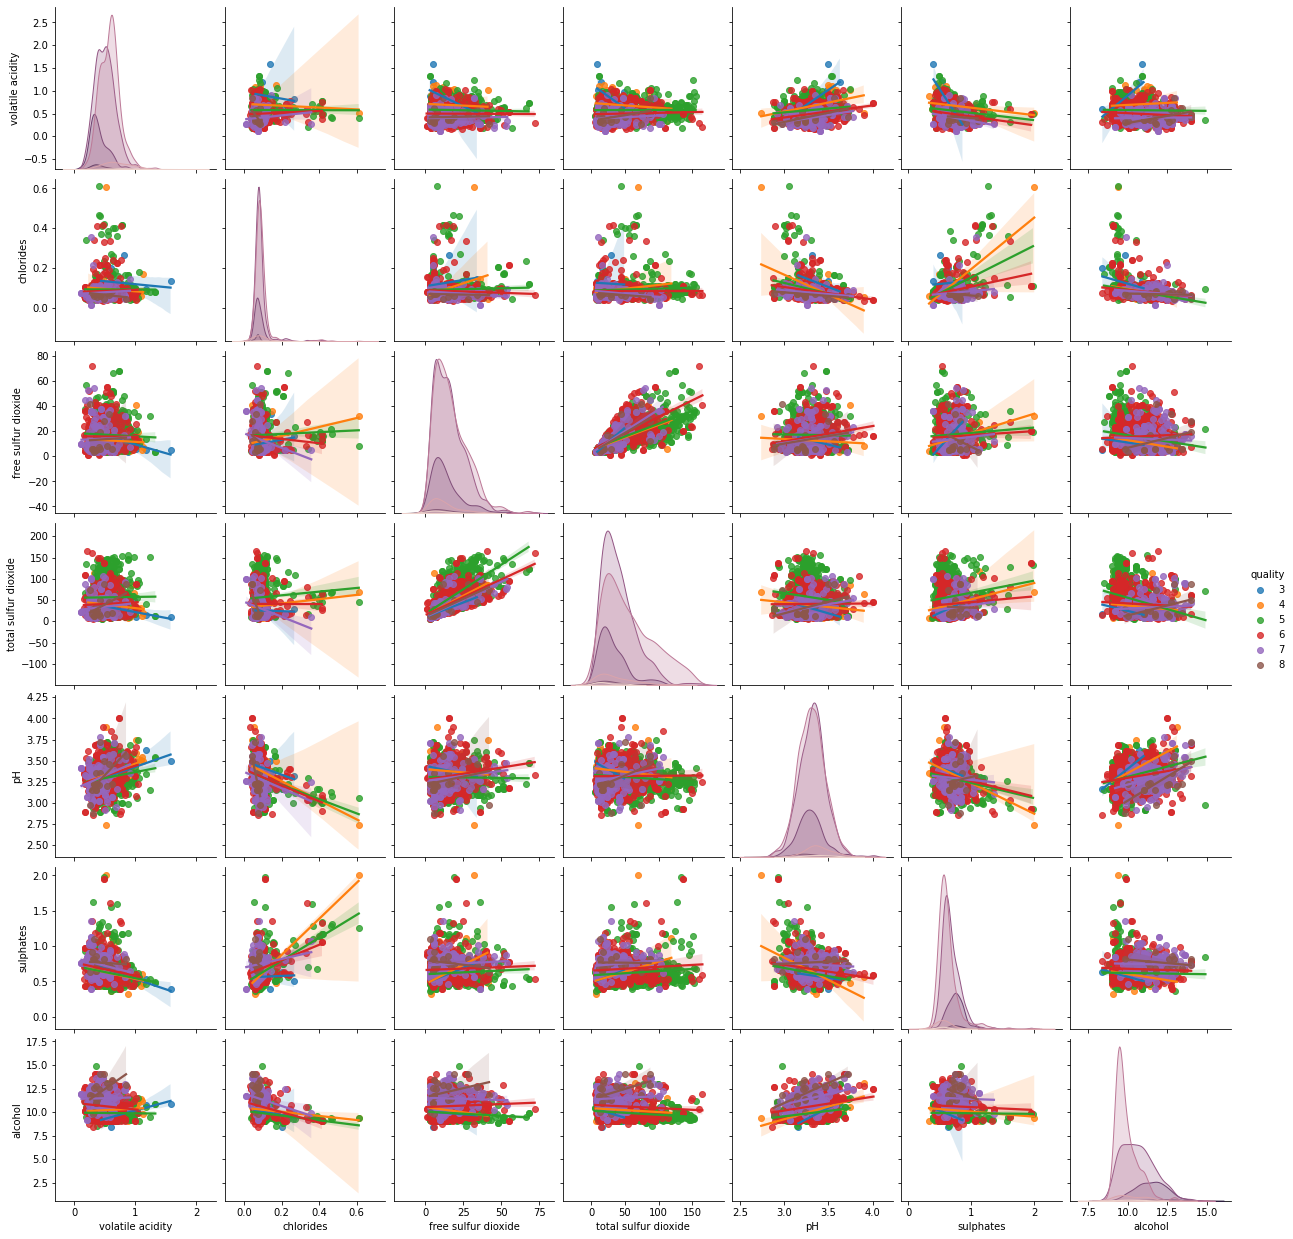

In [34]:
sns.pairplot(df[sig_cols], kind='reg', hue='quality');

## Logistic Regression

In [35]:
df['binquality'] = df['quality'] > df['quality'].mean()

In [36]:
Xcols = [key for key in df.keys() if key not in ['quality', 'binquality']]

In [37]:
model = sm.Logit(df['binquality'], df[Xcols])
results = model.fit(method='newton')
results.summary()

Optimization terminated successfully.
         Current function value: 0.516369
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             binquality   No. Observations:                 1597
Model:                          Logit   Df Residuals:                     1586
Method:                           MLE   Df Model:                           10
Date:                Sun, 13 Mar 2022   Pseudo R-squ.:                  0.2525
Time:                        13:12:14   Log-Likelihood:                -824.64
converged:                       True   LL-Null:                       -1103.2
Covariance Type:            nonrobust   LLR p-value:                2.601e-113
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed acidity            0.1020      0.063      1.609      0.108      -0.022       0.226
volatile acidity        -3.2749      0.485     -6.753      0.000      -4.225      -2.324
citric acid             -1.2889      0.565     -2.280      0.023      -2.397      -0.181
residual sugar           0.0292      0.044      0.671      0.502      -0.056       0.114
chlorides               -3.9542      1.564     -2.528      0.011      -7.020      -0.888
free sulfur dioxide      0.0264      0.008      3.144      0.002       0.010       0.043
total sulfur dioxide    -0.0189      0.003     -6.173      0.000      -0.025      -0.013
density                 -7.2770      2.362     -3.081      0.002     -11.907      -2.647
pH                      -0.4818      0.602     -0.800      0.424      -1.662       0.698
sulphates                2.8220      0.439      6.428      0.000       1.961       3.682
alcohol                  0.8804      0.074     11.856      0.000       0.735       1.026
========================================================================================
"""

In [38]:
sig_cols_logit = list(results.pvalues[results.pvalues < .05].keys())
print("Significant predictors from the logistic regression:", "\n".join(sig_cols_logit), sep='\n')
print('-----------------------------------------------------')
print("Significant predictors from the standard regression:", "\n".join(sig_cols[:-1]), sep='\n')

Significant predictors from the logistic regression:
volatile acidity
citric acid
chlorides
free sulfur dioxide
total sulfur dioxide
density
sulphates
alcohol
-----------------------------------------------------
Significant predictors from the standard regression:
volatile acidity
chlorides
free sulfur dioxide
total sulfur dioxide
pH
sulphates
alcohol
